<a href="https://colab.research.google.com/github/EmilliAshleyMartinez/SIMULACION-1/blob/main/EJEMPLO55_COSSBU_MTZPEREA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EJEMPLO 5.5 INVENTARIOS COSS BU

Elaboró: **MARTINEZ PEREA EMILLI ASHLEY**

Código que simula el comportamiento de un inventario, en función de la cantidad y punto de reorden para estimar los costos del mismo. El ejemplo proporciona una aproximación de la resolución analítica del comportamiento del inventario durante un año, nos baseremos en esta información para concretar la simulación.

In [64]:
from random import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t as Tt

El ejemplo proporciona la distribución de la demanda calculada por transformada inversa, en `transformada_demanda` guardamos los casos de los intervalos de R y el valor que retornaría si se encuentra en ese intervalo, luego la función `demanda` ya se encarga de hacer la simulación del comportamiento real.
En este mismo bloque se definen otros datos ya proporcionados.

In [57]:
transformada_demanda = [
    (0.000, 0.010, 35), (0.010, 0.025, 36), (0.025, 0.045, 37), (0.045, 0.065, 38), (0.065, 0.087, 39),
    (0.087, 0.110, 40), (0.110, 0.135, 41), (0.135, 0.162, 42), (0.162, 0.190, 43), (0.190, 0.219, 44),
    (0.219, 0.254, 45), (0.254, 0.299, 46), (0.299, 0.359, 47), (0.359, 0.424, 48), (0.424, 0.494, 49),
    (0.494, 0.574, 50), (0.574, 0.649, 51), (0.649, 0.719, 52), (0.719, 0.784, 53), (0.784, 0.844, 54),
    (0.844, 0.894, 55), (0.894, 0.934, 56), (0.934, 0.964, 57), (0.964, 0.984, 58), (0.984, 0.999, 59),
    (0.999, 1.001, 60)
]

def demanda():
    r=random()
    for (a, b, d) in transformada_demanda:
        if a <= r < b:
            return d
    return 60

# Distribución de probabilidad del tiempo de entrega de los pedidos
def tiempo_entrega():
    r=random()
    return 1 if r < 0.30 else 2 if r < 0.70 else 3

#factores estacionales
fact_est = [1.20, 1.00, 0.90, 0.80, 0.80, 0.70, 0.80, 0.90, 1.00, 1.20, 1.30, 1.40]
meses = ("Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre")

En esta parte del código comienza la **simulación del inventario**, cada parte importante del funcionamiento esta comentada en su respectiva línea:

In [60]:
def inventario(in_inicial, R, q, n):
    resultados_costos = {
        "Costo_Pedido": [],
        "Costo_Almacenamiento": [],
        "Costo_Faltantes": [],
        "Costo_Total": []
    }

    for simulacion in range(n):
        ini = np.zeros(12, dtype=int)
        fin = np.zeros(12, dtype=int)
        dem = np.zeros(12, dtype=int)
        faltas = np.zeros(12, dtype=int)
        pedidos = np.zeros(12, dtype=int)
        promedio = np.zeros(12, dtype=int)

        ini[0] = in_inicial
        dem[0] = round(demanda() * fact_est[0])
        fin[0] = ini[0] - dem[0]
        promedio[0] = (ini[0] + fin[0]) / 2

        if fin[0] <= R:
            retraso = tiempo_entrega()
            sin_entrega = 0
            pedidos[0] = 1
            if 1 + retraso < 12:
                ini[1 + retraso] += q

        for m in range(1, 12):
            ini[m] += fin[m - 1]
            dem[m] = round(demanda() * fact_est[m])

            if ini[m] < dem[m]:
                faltas[m] = dem[m] - ini[m]
                promedio[m] = (ini[m] ** 2) / (2 * dem[m])

                llegada = m + retraso - sin_entrega
                if llegada < 12:
                    ini[llegada] -= faltas[m]
            else:
                fin[m] = ini[m] - dem[m]
                promedio[m] = (ini[m] + fin[m]) / 2

            if np.sum(pedidos) == 0 and fin[m] <= R:
                retraso = tiempo_entrega()
                sin_entrega = 0
                pedidos[m] = 1
                if m + 1 + retraso < 12:
                    ini[m + 1 + retraso] += q
            elif fin[m] <= R and retraso <= sin_entrega:
                sin_entrega = 0
                pedidos[m] += 1
                retraso = tiempo_entrega()
                if m + 1 + retraso < 12:
                    ini[m + 1 + retraso] += q
            else:
                sin_entrega += 1

        if simulacion == 0:
            df_resultado = pd.DataFrame({
                "Mes": meses,
                "Stock Inicial": ini,
                "Demanda": dem,
                "Stock Final": fin,
                "Faltantes": faltas,
                "Pedidos": pedidos,
                "Inventario Promedio": promedio
            })

        resultados_costos["Costo_Pedido"].append(np.sum(pedidos) * 100)
        resultados_costos["Costo_Almacenamiento"].append(np.sum(promedio) * (20 / 12))
        resultados_costos["Costo_Faltantes"].append(np.sum(faltas) * 50)

        total = (
            resultados_costos["Costo_Pedido"][-1] +
            resultados_costos["Costo_Almacenamiento"][-1] +
            resultados_costos["Costo_Faltantes"][-1]
        )
        resultados_costos["Costo_Total"].append(total)

    df_costos = pd.DataFrame(resultados_costos)
    return df_resultado, df_costos

Simulación y gráfica del inventario durante un año q=200 R=100

,Mes,Stock Inicial,Demanda,Stock Final,Faltantes,Pedidos,Inventario Promedio
0,Enero,150,64,86,0,1,118
1,Febrero,86,47,39,0,0,62
2,Marzo,39,44,0,5,0,17
3,Abril,195,30,165,0,0,180
4,Mayo,165,38,127,0,0,146
5,Junio,127,38,89,0,1,108
6,Julio,89,43,46,0,0,67
7,Agosto,246,50,196,0,0,221
8,Septiembre,196,40,156,0,0,176
9,Octubre,156,71,85,0,1,120


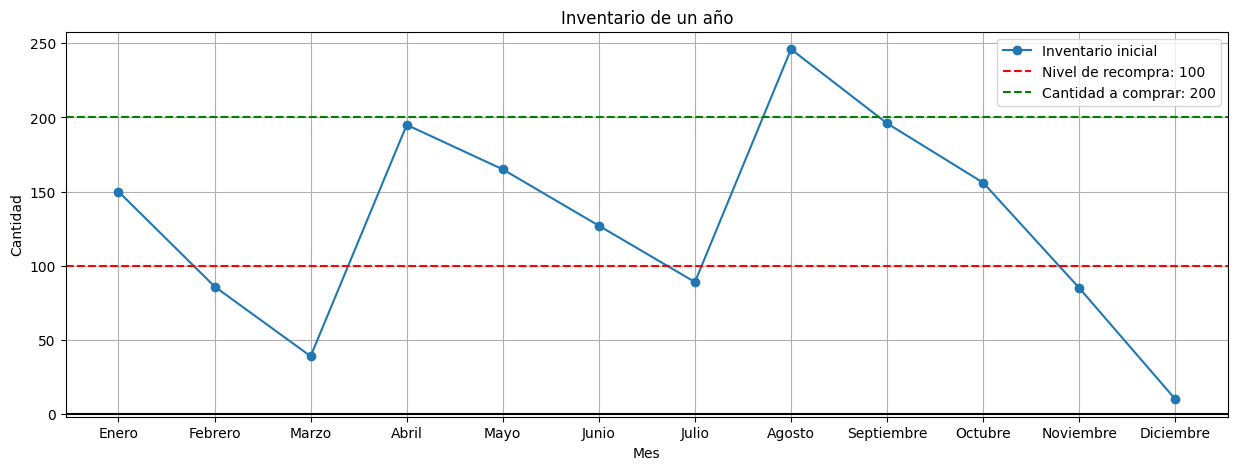

Costo por ordenar: $300.00
Costo por llevar inventario: $2,103.33
Costo por faltante: $2,350.00
Costo total: $4,753.33


In [61]:
inventario_0 = 150
recompra = 100
compra = 200

data, costos = inventario(inventario_0, recompra, compra, 1)

display(data)

plt.figure(figsize=(15, 5))
plt.plot(list(data["Stock Inicial"]), marker = "o", label = "Inventario inicial")
plt.axhline(y = recompra, color = "r", linestyle = "--", label = f"Nivel de recompra: {recompra}")
plt.axhline(y = compra, color = "g", linestyle = "--", label = f"Cantidad a comprar: {compra}")
plt.axhline(y = 0, color = "k")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.title("Inventario de un año")
plt.legend(loc = "best")
plt.grid(True)
plt.xticks(range(12), meses)
plt.show()


print(f"Costo por ordenar: ${costos['Costo_Pedido'].mean():,.2f}")
print(f"Costo por llevar inventario: ${costos['Costo_Almacenamiento'].mean():,.2f}")
print(f"Costo por faltante: ${costos['Costo_Faltantes'].mean():,.2f}")
print(f"Costo total: ${costos['Costo_Total'].mean():,.2f}")

Simulación del inventario n veces

In [66]:
n = 100
x = []
for i in range(1, n + 1):
  _, costos = inventario(inventario_0, recompra, compra, i)
  x.append(np.mean(costos["Costo_Total"]))

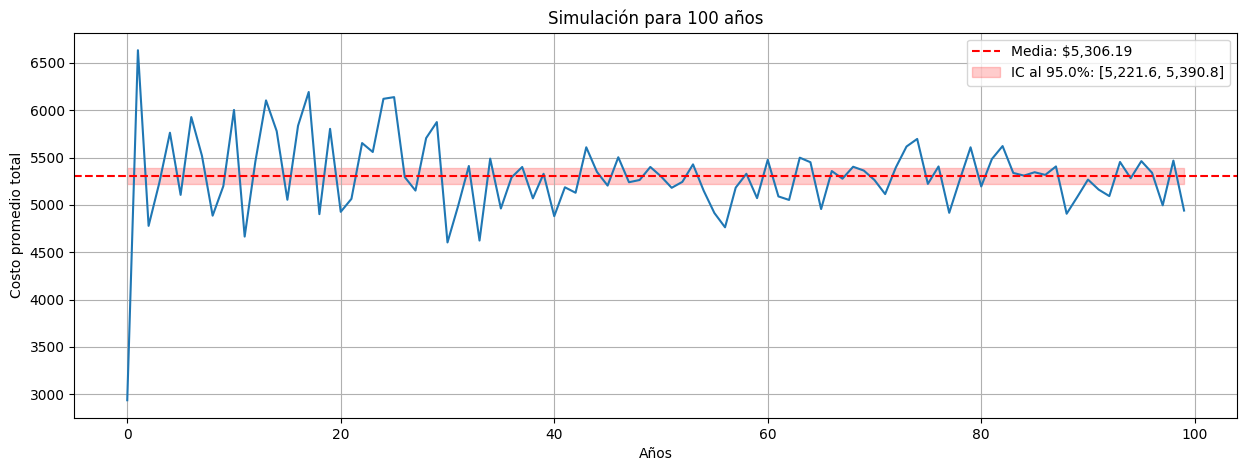

In [67]:
mu = np.mean(x)
s = np.std(x, ddof = 1)
alpha = 0.05
t_critico = Tt.ppf(1 - alpha/2, df = n - 2)
E = t_critico*s/np.sqrt(n)


plt.figure(figsize=(15, 5))
plt.plot(x)
plt.axhline(y = mu, color = "r", linestyle = "--", label = f"Media: ${mu:,.2f}")
plt.fill_between(range(n), mu - E, mu + E, color = "r", alpha = 0.2, label = f"IC al {(1-alpha)*100}%: [{(mu - E):,.1f}, {(mu + E):,.1f}]")
plt.xlabel("Años")
plt.ylabel("Costo promedio total")
plt.title(f"Simulación para {n} años")
plt.legend(loc = "best")
plt.grid(True)
plt.show()